In [1]:
from pathlib import Path
import glob
import exiftool
import soundfile as sf

In [27]:
import numpy as np
import scipy
import pandas as pd
import dask.dataframe as dd
import librosa

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import datetime as dt
import pytz
from tqdm import tqdm

In [4]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from cfg import get_config
from pipeline import pipeline
from utils.utils import gen_empty_df, convert_df_ravenpro

In [5]:
def plot_audio_seg(audio_features, spec_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()


def plot_dets_over_audio(audio_features, spec_features, plot_dets):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)

    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()

In [6]:
def generate_segments(audio_file: Path, output_dir: Path, start_time: float, duration: float):
    """
    Segments audio file into clips of duration length and saves them to output/tmp folder.
    Allows detection model to be run on segments instead of entire file as recommended.
    These segments will be deleted from the output/tmp folder after detections have been generated.

    Parameters
    ------------
    audio_file : `pathlib.Path`
        - The path to an audio_file from the input directory provided in the command line
    output_dir : `pathlib.Path`
        - The path to the tmp folder that saves all of our segments.
    start_time : `float`
        - The time at which the segments will start being generated from within the audio file
    duration : `float`
        - The duration of all segments generated from the audio file.

    Returns
    ------------
    output_files : `List`
        - The path (a str) to each generated segment of the given audio file will be stored in this list.
        - The offset of each generated segment of the given audio file will be stored in this list.
        - Both items are stored in a dict{} for each generated segment.
    """
    
    ip_audio = sf.SoundFile(audio_file)

    sampling_rate = ip_audio.samplerate
    # Convert to sampled units
    ip_start = int(start_time * sampling_rate)
    ip_duration = int(duration * sampling_rate)
    ip_end = ip_audio.frames

    output_files = []

    # for the length of the duration, process the audio into duration length clips
    for sub_start in range(ip_start, ip_end, ip_duration):
        sub_end = np.minimum(sub_start + ip_duration, ip_end)

        # For file names, convert back to seconds 
        op_file = audio_file.name.replace(" ", "_")
        start_seconds =  sub_start / sampling_rate
        end_seconds =  sub_end / sampling_rate
        op_file_en = "__{:.2f}".format(start_seconds) + "_" + "{:.2f}".format(end_seconds)
        op_file = op_file[:-4] + op_file_en + ".wav"
        
        op_path = output_dir / op_file
        output_files.append({
            "input_filepath": audio_file,
            "audio_file": op_path, 
            "offset":  start_time + (sub_start/sampling_rate),
        })
        
        if (not(op_path.exists())):
            sub_length = sub_end - sub_start
            ip_audio.seek(sub_start)
            op_audio = ip_audio.read(sub_length)
            sf.write(op_path, op_audio, sampling_rate, subtype='PCM_16')

    return output_files 

def generate_segmented_paths(audio_files, cfg):
    """
    Generates and returns a list of segments using provided cfg parameters for each audio file in audio_files.

    Parameters
    ------------
    audio_files : `List`
        - List of pathlib.Path objects of the paths to each audio file in the provided input directory.
    cfg : `dict`
        - A dictionary of pipeline parameters:
        - tmp_dir is the directory where segments will be stored
        - start_time is the time at which segments are generated from each audio file.
        - segment_duration is the duration of each generated segment

    Returns
    ------------
    segmented_file_paths : `List`
        - A list of dictionaries related to every generated segment.
        - Each dictionary stores a generated segment's path in the tmp_dir and offset in the original audio file.
    """

    segmented_file_paths = []
    for audio_file in audio_files:
        segmented_file_paths += generate_segments(
            audio_file = audio_file, 
            output_dir = cfg['tmp_dir'],
            start_time = cfg['start_time'],
            duration   = cfg['segment_duration'],
        )
    return segmented_file_paths


def initialize_mappings(necessary_paths, cfg):
    """
    Generates and returns a list of mappings using provided cfg parameters for each audio segment in the provided necessary paths.

    Parameters
    ------------
    necessary_paths : `List`
        - List of dictionaries generated by generate_segmented_paths()
    cfg : `dict`
        - A dictionary of pipeline parameters:
        - models is the models in the pipeline that are being used.

    Returns
    ------------
    l_for_mapping : `List`
        - A list of dictionaries related to every generated segment with more pipeline details.
        - Each dictionary stores the prior segmented_path dict{}, the model to apply, and the original file name of the segment.
    """

    l_for_mapping = [{
        'audio_seg': audio_seg, 
        'model': cfg['models'][0],
        'original_file_name': audio_seg["input_filepath"],
        } for audio_seg in necessary_paths]

    return l_for_mapping

In [7]:
def run_models(file_mappings):
    """
    Runs the batdetect2 model to detect bat search-phase calls in the provided audio segments and saves detections into a .csv.

    Parameters
    ------------
    file_mappings : `List`
        - List of dictionaries generated by initialize_mappings()

    Returns
    ------------
    bd_dets : `pandas.DataFrame`
        - A DataFrame of detections that will also be saved in the provided output_dir under the above csv_name
        - 7 columns in this DataFrame: start_time, end_time, low_freq, high_freq, detection_confidence, event, input_file
        - Detections are always specified w.r.t their input_file; earliest start_time can be 0 and latest end_time can be 1795.
        - Events are always "Echolocation" as we are using a model that only detects search-phase calls.
    """

    bd_dets = pd.DataFrame()
    for i in tqdm(range(len(file_mappings))):
        cur_seg = file_mappings[i]
        bd_annotations_df = cur_seg['model']._run_batdetect(cur_seg['audio_seg']['audio_file'])
        bd_preds = pipeline._correct_annotation_offsets(
                bd_annotations_df,
                cur_seg['original_file_name'],
                cur_seg['audio_seg']['offset']
            )
        bd_dets = pd.concat([bd_dets, bd_preds])

    return bd_dets

def _save_predictions(annotation_df, output_dir, cfg):
    """
    Saves a dataframe to the format that user desires: ravenpro .txt or .csv
    """
        
    extension = ".csv"
    sep = ","

    if not cfg["should_csv"]:
        extension = ".txt"
        sep = "\t"
        annotation_df = convert_df_ravenpro(annotation_df)

    filename = f"{cfg['csv_filename']}{extension}"

    csv_path = output_dir / filename
    annotation_df.to_csv(csv_path, sep=sep, index=False)
    return csv_path

def delete_segments(necessary_paths):
    """
    Deletes the segments whose paths are stored in necessary_paths

    Parameters
    ------------
    necessary_paths : `List`
        - A list of dictionaries generated from generate_segmented_paths()
    """

    for path in necessary_paths:
        path['audio_file'].unlink(missing_ok=False)

def run_pipeline_on_file(file, cfg):
    bd_preds = pd.DataFrame()

    if not cfg['output_dir'].is_dir():
        cfg['output_dir'].mkdir(parents=True, exist_ok=True)
    if not cfg['tmp_dir'].is_dir():
        cfg['tmp_dir'].mkdir(parents=True, exist_ok=True)

    if (cfg['run_model']):
        cfg["csv_filename"] = f"batdetect2_pipeline_{file.name.split('.')[0]}2"
        print(f"Generating detections for {file.name}")
        segmented_file_paths = generate_segmented_paths([file], cfg)
        file_path_mappings = initialize_mappings(segmented_file_paths, cfg)
        bd_preds = run_models(file_path_mappings)
        if cfg['save']:
            _save_predictions(bd_preds, cfg['output_dir'], cfg)
        delete_segments(segmented_file_paths)

    return bd_preds

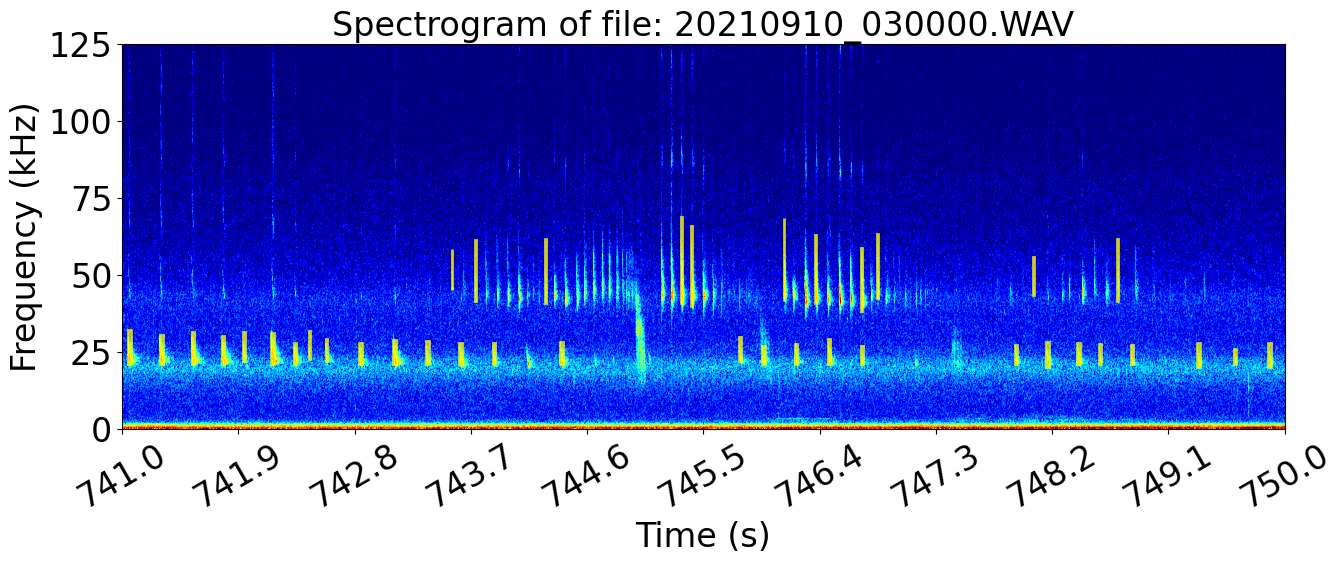

In [8]:
input_file1 = Path('../../Documents/Research/Lab_related/example/original_recording/recover-20210912_unit2/UBNA_002/20210910_030000.WAV')

cfg = get_config()
cfg['input_audio'] = Path(input_file1)
cfg['tmp_dir'] = Path('../output/tmp')
cfg['output_dir'] = Path('../output_dir/recover-20210912/Foliage/')
cfg['run_model'] = True
cfg['should_csv'] = True
cfg['save'] = True

filename = input_file1.name.split('.')[0]
original_file_dets = pd.read_csv(f'../output_dir/recover-20210912/Foliage/bd2_{filename}.csv')
audio_data = sf.SoundFile(input_file1)
fs = audio_data.samplerate
start = 741
duration = 9
end = int(start+duration)
audio_data.seek(int(fs*start))
audio_seg = audio_data.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 50 # hide anything below -rm_dB dB
vmax = 20*np.log10(np.max(audio_seg)) + 0 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = input_file1
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin
spec_features['vmax'] = vmax
spec_features['plot_title'] = f"Spectrogram of file: {audio_features['file_path'].name}"

window_cond = np.logical_and(original_file_dets['start_time'] > start, original_file_dets['end_time'] < (start+duration))
section_og_file_dets = original_file_dets.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, section_og_file_dets)

In [9]:
input_file2 = Path('../../Documents/Research/Lab_related/example/original_recording/recover-20210912_unit2/UBNA_002/20210910_030000.WAV')
# audio_file = sf.SoundFile(input_file)
# fs = audio_file.samplerate
# audio_data = audio_file.read()
pad_dur = 1
# padded_audio_data = np.pad(audio_data, pad_width=(pad_dur*fs, 0))

filename = input_file2.name.split('.')[0]
write_file = Path(f'../../Downloads/{filename}_{pad_dur}spad.WAV')
# sf.write(write_file, padded_audio_data, fs)
# padded_file_dets = run_pipeline_on_file(write_file, cfg)

In [10]:
padded_file_dets = pd.read_csv(f'../output_dir/recover-20210912/Foliage/batdetect2_pipeline_{filename}_{pad_dur}spad.csv')

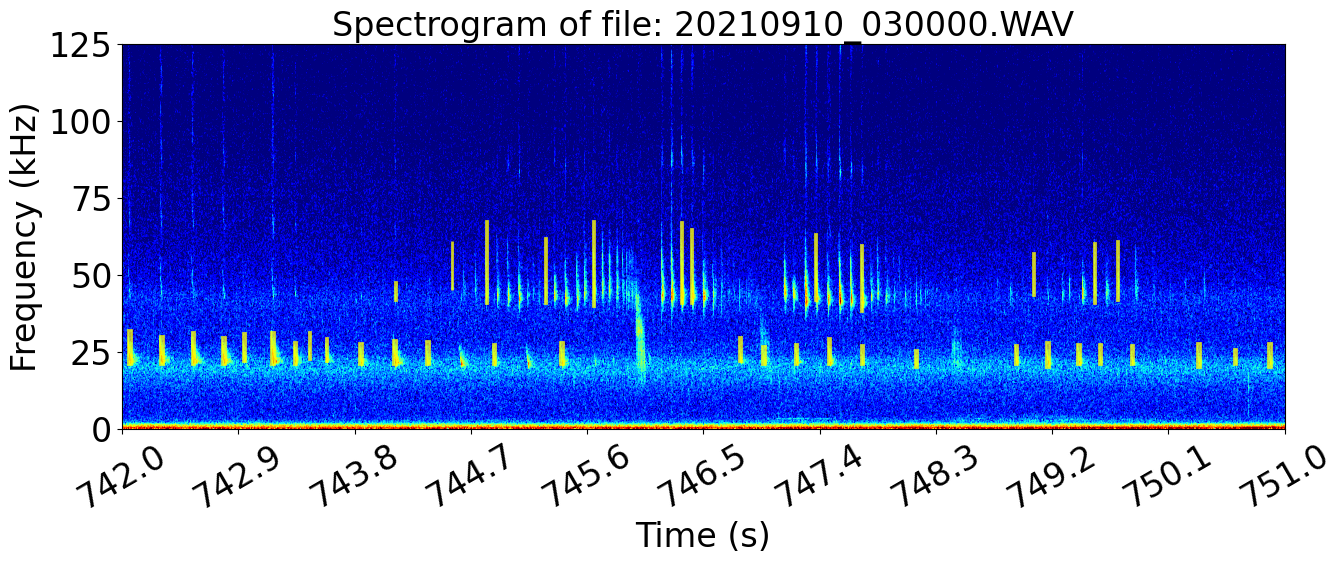

In [11]:
input_file2 = Path(write_file)

cfg = get_config()
cfg['input_audio'] = input_file2
cfg['tmp_dir'] = Path('../output/tmp')
cfg['output_dir'] = Path('../output_dir')
cfg['run_model'] = True
cfg['should_csv'] = True
cfg['save'] = False

audio_file = sf.SoundFile(input_file2)
fs = audio_file.samplerate
start = 742
duration = 9
end = int(start+duration)
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))

audio_features = dict()
audio_features['file_path'] = input_file2
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

window_cond = np.logical_and(padded_file_dets['start_time'] > start, padded_file_dets['end_time'] < (start+duration))
plt_file_dets1 = padded_file_dets.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, plt_file_dets1)

In [12]:
corrected_file_dets = padded_file_dets.copy()
corrected_file_dets['start_time'] -= 1
corrected_file_dets['end_time'] -= 1

ogsec_test1 = original_file_dets.set_index('start_time')
padsec_test1 = corrected_file_dets.set_index('start_time')
new_dets1 = padsec_test1.loc[padsec_test1.index.difference(ogsec_test1.index)]

ogsec_test2 = original_file_dets.set_index('end_time')
padsec_test2 = new_dets1.reset_index().set_index('end_time')
new_dets2 = padsec_test2.loc[padsec_test2.index.difference(ogsec_test2.index)]

combined_test1 = pd.concat([ogsec_test1.reset_index(), new_dets2.reset_index()])

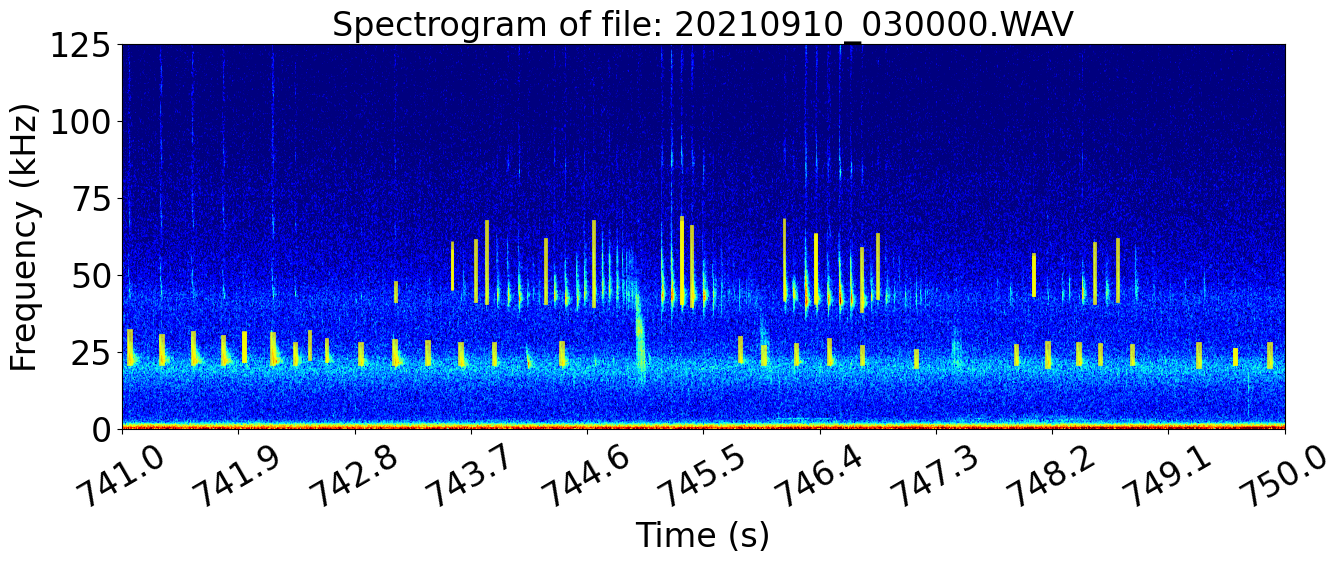

In [13]:
cfg = get_config()
cfg['input_audio'] = input_file1
cfg['tmp_dir'] = Path('../output/tmp')
cfg['output_dir'] = Path('../output_dir')
cfg['run_model'] = True
cfg['should_csv'] = True
cfg['save'] = False

audio_data = sf.SoundFile(input_file1)
fs = audio_data.samplerate
start = 741
duration = 9
end = int(start+duration)
audio_data.seek(int(fs*start))
audio_seg = audio_data.read(int(fs*duration))

audio_features = dict()
audio_features['file_path'] = input_file1
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

window_cond = np.logical_and(combined_test1['start_time'] > start, combined_test1['end_time'] < (start+duration))
plt_file_dets2 = combined_test1.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, plt_file_dets2)

In [14]:
def check_neighboring_for_no_freq_overlap(section):    
    test_group = section.reset_index()

    return_df = test_group.copy()
    if len(test_group)>1 and np.isclose(test_group.loc[0,'low_freq'], test_group.loc[1,'low_freq'], atol=1000):
        return_df = test_group.head(1)

    return return_df

In [15]:
file_dts = pd.to_datetime(combined_test1['input_file'], format='%Y%m%d_%H%M%S', exact=False) 
combined_test1.insert(0, 'call_start_time', file_dts + pd.to_timedelta(combined_test1['start_time'].values.astype('float64'), unit='S'))
combined_test1.insert(0, 'call_end_time', file_dts + pd.to_timedelta(combined_test1['end_time'].values.astype('float64'), unit='S'))
combined_test1.insert(0, 'ref_time', file_dts + pd.to_timedelta(combined_test1['start_time'].values.astype('float64'), unit='S'))

sorted_result = combined_test1.sort_values(by='start_time')
sorted_result = sorted_result.set_index('ref_time')

removed_overlaps = sorted_result.resample('0.01S').apply(lambda x : check_neighboring_for_no_freq_overlap(x))
removed_overlaps.reset_index(drop=True, inplace=True)

In [16]:
# test_group = sorted_result.loc[(sorted_result['call_start_time']>=dt.datetime(2021,9,10,3,12,25,322500))&(sorted_result['call_start_time']<=dt.datetime(2021,9,10,3,12,25,325000))]
# test_group

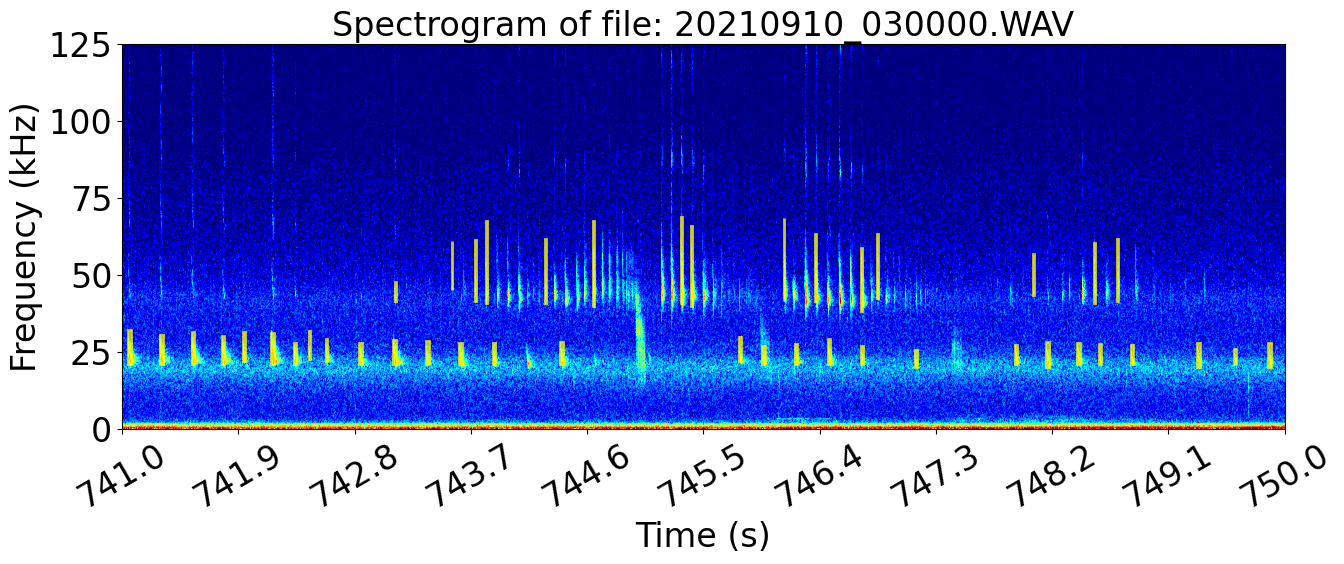

In [17]:
cfg = get_config()
cfg['input_audio'] = input_file1
cfg['tmp_dir'] = Path('../output/tmp')
cfg['output_dir'] = Path('../output_dir')
cfg['run_model'] = True
cfg['should_csv'] = True
cfg['save'] = False

audio_data = sf.SoundFile(input_file1)
fs = audio_data.samplerate
start = 741
duration = 9
end = int(start+duration)
audio_data.seek(int(fs*start))
audio_seg = audio_data.read(int(fs*duration))

audio_features = dict()
audio_features['file_path'] = input_file1
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

window_cond = np.logical_and(removed_overlaps['start_time'] > start, removed_overlaps['end_time'] < (start+duration))
plt_file_dets3 = removed_overlaps.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, plt_file_dets3)

In [18]:
plt_file_dets1.shape

(40, 10)

In [19]:
section_og_file_dets.shape

(39, 13)

In [20]:
plt_file_dets2.shape

(50, 13)

In [21]:
plt_file_dets3.shape

(44, 16)

In [22]:
padded_file_dets.shape

(3203, 10)

In [23]:
original_file_dets.shape

(3211, 13)

In [24]:
combined_test1.shape

(3736, 16)

In [25]:
removed_overlaps.shape

(3359, 16)